In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing as mp
from genespectra.gene_classification.classify_genes import ExpressionDataLong, GeneClassificationResult
from genespectra.metacells.make_metacells import SummedAnnData
sns.set_theme(rc={'figure.dpi': 100, 'figure.figsize': (2, 2)})

/nfs/research/icortes/ysong/anaconda3/envs/metacells_py/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read_h5ad("../../metacells/gorilla_metacells_subclass.h5ad")

In [3]:
adata.obs

,grouped,total_umis,__zeros_downsample_umis,metacells_rare_gene_module,rare_metacell,cell_type,cell_type_fraction_of_L2/3-6 intratelencephalic projecting glutamatergic cortical neuron,cell_type_fraction_of_L5 extratelencephalic projecting glutamatergic cortical neuron,cell_type_fraction_of_L6b glutamatergic cortical neuron,cell_type_fraction_of_astrocyte of the cerebral cortex,...,Subclass_fraction_of_Micro-PVM,Subclass_fraction_of_OPC,Subclass_fraction_of_Oligo,Subclass_fraction_of_Pax6,Subclass_fraction_of_Pvalb,Subclass_fraction_of_Sncg,Subclass_fraction_of_Sst,Subclass_fraction_of_Sst Chodl,Subclass_fraction_of_VLMC,Subclass_fraction_of_Vip
M0.07,17,306860,11439,-1,False,lamp5 GABAergic cortical interneuron,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
M1.61,22,307869,7596,-1,False,lamp5 GABAergic cortical interneuron,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
M2.91,17,293368,9824,-1,False,lamp5 GABAergic cortical interneuron,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
M3.62,18,315128,7047,-1,False,lamp5 GABAergic cortical interneuron,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
M4.40,24,320004,6092,-1,False,lamp5 GABAergic cortical interneuron,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M6496.49,15,308122,13038,-1,False,pvalb GABAergic cortical interneuron,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0
M6497.81,12,225234,10850,-1,False,sncg GABAergic cortical interneuron,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,0.75,0.0,0.0,0.0,0.0
M6498.04,12,320822,14747,-1,False,pvalb GABAergic cortical interneuron,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0
M6499.54,13,296130,17047,-1,False,lamp5 GABAergic cortical interneuron,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0


In [4]:
adata.obs['Subclass'] = adata.obs['Subclass'].astype(str)

In [5]:
import pandas as pd

# Given mapping
mapping = {
    'Astro': 'astrocyte of the cerebral cortex',
    'Oligo': 'oligodendrocyte',
    'VLMC': 'vascular leptomeningeal cell',
    'Micro-PVM': 'microglial cell',
    'OPC': 'oligodendrocyte precursor cell',
    'Endo': 'cerebral cortex endothelial cell',
    'L5/6 NP': 'near-projecting glutamatergic cortical neuron',
    'L6 CT': 'corticothalamic-projecting glutamatergic cortical neuron',
    'L6b': 'L6b glutamatergic cortical neuron',
    'L5 ET': 'L5 extratelencephalic projecting glutamatergic cortical neuron',
    'Pax6': 'caudal ganglionic eminence derived GABAergic cortical interneuron',
    'Vip': 'vip GABAergic cortical interneuron',
    'Sncg': 'sncg GABAergic cortical interneuron',
    'Lamp5_Lhx6': 'lamp5 GABAergic cortical interneuron',
    'Lamp5': 'lamp5 GABAergic cortical interneuron',
    'Sst Chodl': 'sst GABAergic cortical interneuron',
    'Pvalb': 'pvalb GABAergic cortical interneuron',
    'Sst': 'sst GABAergic cortical interneuron',
    'Chandelier': 'chandelier pvalb GABAergic cortical interneuron',
    'L5 IT': 'L5 intratelencephalic projecting glutamatergic neuron',
    'L4 IT': 'L4 intratelencephalic projecting glutamatergic neuron',
    'L2/3 IT': 'L2/3 intratelencephalic projecting glutamatergic neuron',
    'L6 IT Car3': 'L6 intratelencephalic projecting glutamatergic neuron',
    'L6 IT': 'L6 intratelencephalic projecting glutamatergic neuron'
}


In [6]:
for key in mapping:
    print(key)
    adata.obs['Subclass'] = adata.obs['Subclass'].str.replace(key, mapping[key])
    

Astro
Oligo
VLMC
Micro-PVM
OPC
Endo
L5/6 NP
L6 CT
L6b
L5 ET
Pax6
Vip
Sncg
Lamp5_Lhx6
Lamp5
Sst Chodl
Pvalb
Sst
Chandelier
L5 IT
L4 IT
L2/3 IT
L6 IT Car3
L6 IT


In [7]:
adata.obs.Subclass.astype('category').cat.categories

Index(['L2/3 intratelencephalic projecting glutamatergic neuron',
       'L4 intratelencephalic projecting glutamatergic neuron',
       'L5 extratelencephalic projecting glutamatergic cortical neuron',
       'L5 intratelencephalic projecting glutamatergic neuron',
       'L6 intratelencephalic projecting glutamatergic neuron',
       'L6b glutamatergic cortical neuron', 'astrocyte of the cerebral cortex',
       'caudal ganglionic eminence derived GABAergic cortical interneuron',
       'cerebral cortex endothelial cell',
       'chandelier pvalb GABAergic cortical interneuron',
       'corticothalamic-projecting glutamatergic cortical neuron',
       'lamp5 GABAergic cortical interneuron', 'microglial cell',
       'near-projecting glutamatergic cortical neuron', 'oligodendrocyte',
       'oligodendrocyte precursor cell',
       'pvalb GABAergic cortical interneuron',
       'sncg GABAergic cortical interneuron',
       'sst GABAergic cortical interneuron', 'vascular leptomeningeal 

In [8]:
adata.obs['cell_type_name'] = adata.obs['Subclass']

In [9]:
sc.pp.calculate_qc_metrics(adata, log1p=False, inplace=True)

In [10]:
adata.X.max()

0.11830522

In [11]:
adata.obs['total_counts']

M0.07       1.0
M1.61       1.0
M2.91       1.0
M3.62       1.0
M4.40       1.0
           ... 
M6496.49    1.0
M6497.81    1.0
M6498.04    1.0
M6499.54    1.0
M6500.41    1.0
Name: total_counts, Length: 6501, dtype: float32

In [12]:
adata.var.pct_dropout_by_counts.values

array([99.75388402, 93.43177973, 85.07921858, ...,  0.        ,
       99.938471  , 99.90770651])

In [13]:
## in human protein atlas, they analyzed genes that are expressed in at least 10% of cells as valid
## shall we do this too

<AxesSubplot: ylabel='Count'>

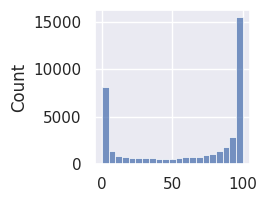

In [14]:
sns.histplot(adata.var.pct_dropout_by_counts.values)

In [15]:
anno_col='cell_type_name'

In [16]:
adata

AnnData object with n_obs × n_vars = 6501 × 41048
    obs: 'grouped', 'total_umis', '__zeros_downsample_umis', 'metacells_rare_gene_module', 'rare_metacell', 'cell_type', 'cell_type_fraction_of_L2/3-6 intratelencephalic projecting glutamatergic cortical neuron', 'cell_type_fraction_of_L5 extratelencephalic projecting glutamatergic cortical neuron', 'cell_type_fraction_of_L6b glutamatergic cortical neuron', 'cell_type_fraction_of_astrocyte of the cerebral cortex', 'cell_type_fraction_of_caudal ganglionic eminence derived GABAergic cortical interneuron', 'cell_type_fraction_of_cerebral cortex endothelial cell', 'cell_type_fraction_of_chandelier pvalb GABAergic cortical interneuron', 'cell_type_fraction_of_corticothalamic-projecting glutamatergic cortical neuron', 'cell_type_fraction_of_lamp5 GABAergic cortical interneuron', 'cell_type_fraction_of_microglial cell', 'cell_type_fraction_of_near-projecting glutamatergic cortical neuron', 'cell_type_fraction_of_oligodendrocyte', 'cell_type_fr

In [17]:
summed_adata = SummedAnnData(summed_adata=adata)
## just assign the metacell anndata to summed_adata object

In [18]:
summed_adata.__class__

genespectra.metacells.make_metacells.SummedAnnData

In [19]:
# normalize to a fixed size factor
summed_adata = SummedAnnData.depth_normalize_counts(summed_adata, target_sum=1000000)
sc.pp.calculate_qc_metrics(summed_adata, log1p=False, inplace=True)

Size factor depth normalize counts
Target total UMI per cell is 1000000
Total UMI count is normalized to [[1000000.]]


In [20]:
summed_adata.count_type

'summed_counts'

In [21]:
len(summed_adata.obs_names)

6501

In [22]:
summed_adata = SummedAnnData.filter_low_counts(summed_adata, min_count=1, min_cells_pct=1)

Genes with min_count 1 are considered low count
Genes with min_cells_pct 1 are considered low count
Put 10205 genes into low counts genes


In [23]:
summed_adata

AnnData object with n_obs × n_vars = 6501 × 30843
    obs: 'grouped', 'total_umis', '__zeros_downsample_umis', 'metacells_rare_gene_module', 'rare_metacell', 'cell_type', 'cell_type_fraction_of_L2/3-6 intratelencephalic projecting glutamatergic cortical neuron', 'cell_type_fraction_of_L5 extratelencephalic projecting glutamatergic cortical neuron', 'cell_type_fraction_of_L6b glutamatergic cortical neuron', 'cell_type_fraction_of_astrocyte of the cerebral cortex', 'cell_type_fraction_of_caudal ganglionic eminence derived GABAergic cortical interneuron', 'cell_type_fraction_of_cerebral cortex endothelial cell', 'cell_type_fraction_of_chandelier pvalb GABAergic cortical interneuron', 'cell_type_fraction_of_corticothalamic-projecting glutamatergic cortical neuron', 'cell_type_fraction_of_lamp5 GABAergic cortical interneuron', 'cell_type_fraction_of_microglial cell', 'cell_type_fraction_of_near-projecting glutamatergic cortical neuron', 'cell_type_fraction_of_oligodendrocyte', 'cell_type_fr

In [24]:
summed_adata.removed_min_count
## remove all genes having less than 1 count per million in metacells

1

In [25]:
summed_adata.removed_min_cells_pct

1

In [26]:
print(f"running gene classification on {len(summed_adata.var_names.values)} genes")
expr_data = ExpressionDataLong.create_from_summed_adata(input_summed_adata=summed_adata, anno_col=anno_col)

running gene classification on 30843 genes
Calculating group average of counts from SummedAnnData


In [27]:
from numpy import percentile

In [28]:
percentile(expr_data.expression, [10, 15, 25, 50, 60, 70, 75])

array([0.007861520722508432, 0.021822536550462252, 0.06597651913762093,
       0.7169721126556396, 1.9903139352798462, 5.499200534820552,
       8.95124864578247], dtype=object)

In [29]:
import seaborn as sns

In [30]:
result_classes = GeneClassificationResult.create_from_expression_data_long_multiprocess(expr_data, max_group_n=None, exp_lim=1, enr_fold=4)

Multiprocessing with 48 cores
Running HPA gene classification 

Running HPA gene classification 
num cell types = 21, num_genes = 3138, max_group=10.0, exp_lim=1

Running HPA gene classification 
Running HPA gene classification 



Running HPA gene classification 
Running HPA gene classification 

num cell types = 21, num_genes = 3011, max_group=10.0, exp_lim=1
Running HPA gene classification 
num cell types = 21, num_genes = 3012, max_group=10.0, exp_lim=1
num cell types = 21, num_genes = 3152, max_group=10.0, exp_lim=1


num cell types = 21, num_genes = 3017, max_group=10.0, exp_lim=1

Running HPA gene classification 


Running HPA gene classification 


num cell types = 21, num_genes = 3131, max_group=10.0, exp_lim=1

Running HPA gene classification 
num cell types = 21, num_genes = 3112, max_group=10.0, exp_lim=1
num cell types = 21, num_genes = 3110, max_group=10.0, exp_lim=1




num cell types = 21, num_genes = 3074, max_group=10.0, exp_lim=1

num cell types = 21, num_genes = 308

/nfs/research/icortes/ysong/anaconda3/envs/metacells_py/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nfs/research/icortes/ysong/anaconda3/envs/metacells_py/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nfs/research/icortes/ysong/anaconda3/envs/metacells_py/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nfs/research/icortes/ysong/anaconda3/envs/metacells_py/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nfs/research/icortes/ysong/anaconda3/envs/metacells_py/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis

finish gene classification with multiprocessing


In [31]:
result_classes.spec_category.value_counts()

low cell type specificity    12606
lowly expressed               9618
cell type enhanced            3716
cell type enriched            2563
group enriched                1573
group enhanced                 767
Name: spec_category, dtype: int64

In [32]:
result_classes

,mean_exp,min_exp,max_exp,max_2nd,n_exp,frac_exp,groups_expressed,groups_not_expressed,lim,gene,...,enrichment_group,n_enriched,max_2nd_or_lim,exps_enhanced,n_enhanced,enhanced_in,spec_category,dist_category,spec_score,enriched_groups
gene,,,,,,,,,,,,,,,,,,,,,
A2M,172.698853,0.206800,1782.958984,1755.849976,4,19.047619,cerebral cortex endothelial cell;microglial ce...,L2/3 intratelencephalic projecting glutamaterg...,445.739746,A2M,...,cerebral cortex endothelial cell;microglial cell,2,1755.849976,"[1755.8499755859375, 1782.958984375]",2,cerebral cortex endothelial cell;microglial cell,group enriched,expressed in less than 30%,22.398319,cerebral cortex endothelial cell;microglial cell
AADACL2-AS1,0.778557,0.294400,1.755400,1.667200,6,28.571429,L5 extratelencephalic projecting glutamatergic...,L2/3 intratelencephalic projecting glutamaterg...,0.438850,AADACL2-AS1,...,L5 extratelencephalic projecting glutamatergic...,0,1.667200,[],0,,low cell type specificity,expressed in less than 30%,0.000000,
AAMP,7.332943,2.557000,11.236800,11.088100,21,100.000000,L2/3 intratelencephalic projecting glutamaterg...,NaN,2.809200,AAMP,...,L2/3 intratelencephalic projecting glutamaterg...,0,11.088100,[],0,,low cell type specificity,expressed in over 90%,0.000000,
ABCA11P,0.253290,0.000000,0.622300,0.448200,0,0.000000,NaN,L2/3 intratelencephalic projecting glutamaterg...,0.155575,ABCA11P,...,,0,0.448200,[],0,,lowly expressed,lowly expressed,0.000000,
ABCB1,301.363373,0.456800,6245.695312,32.584000,19,90.476190,L2/3 intratelencephalic projecting glutamaterg...,astrocyte of the cerebral cortex;oligodendrocyte,1561.423828,ABCB1,...,cerebral cortex endothelial cell,1,1561.423828,[6245.6953125],1,cerebral cortex endothelial cell,cell type enriched,expressed in over 90%,191.679825,cerebral cortex endothelial cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZP3,18.475468,7.246800,55.050999,52.359001,21,100.000000,L2/3 intratelencephalic projecting glutamaterg...,NaN,13.762750,ZP3,...,L5 extratelencephalic projecting glutamatergic...,0,52.359001,[],0,,low cell type specificity,expressed in over 90%,0.000000,
ZSWIM3,4.212752,2.566400,9.748800,5.565200,21,100.000000,L2/3 intratelencephalic projecting glutamaterg...,NaN,2.437200,ZSWIM3,...,L2/3 intratelencephalic projecting glutamaterg...,0,5.565200,[],0,,low cell type specificity,expressed in over 90%,0.000000,
ZSWIM6,630.660034,57.197899,3122.945312,2607.222656,21,100.000000,L2/3 intratelencephalic projecting glutamaterg...,NaN,780.736328,ZSWIM6,...,astrocyte of the cerebral cortex;microglial ce...,2,2607.222656,"[2607.22265625, 3122.9453125]",2,microglial cell;oligodendrocyte precursor cell,group enhanced,expressed in over 90%,4.951868,microglial cell;oligodendrocyte precursor cell


In [33]:
result_classes.dist_category.value_counts()

expressed in over 90%         11713
lowly expressed                9618
expressed in less than 30%     3709
expressed in over 30%          3350
expressed in single            2453
Name: dist_category, dtype: int64

In [34]:
from genespectra.gene_classification.plotting import plot_categories_pie, plot_categories_hist

In [35]:
import plotly.io as pio
pio.renderers.default='iframe'
from plotly.graph_objects import Figure
import plotly.express as px

In [36]:
def plot_categories_pie(data, kind='spec_category', title=None) -> Figure:
    """

    :param data: the categories output by hpa_gene_classification
    :param kind: the kind of category to plot, choose between spec_category (default) and dist_category
    :param title: title of the plot, usually the species and dataset name
    :return: a plotly.graph_objects.Figure of Pie plot
    """
    if kind not in ('spec_category', 'dist_category'):
        raise ValueError('kind should be either spec_category or dist_category')

    counts = data[kind].value_counts().to_frame().reset_index().rename(
        columns={kind: "counts", "index": 'gene_category'})
    fig = px.pie(counts, values='counts', names='gene_category', title=title)
    fig.show(renderer='iframe')

    return fig


In [37]:
plot_categories_pie(result_classes)

In [38]:
result_classes.n_exp.value_counts().to_frame().sort_index()

,n_exp
0,9618
1,2453
2,1277
3,917
4,592
5,488
6,435
7,332
8,299
9,255


In [39]:
plot_categories_hist(result_classes)

In [40]:
result_classes.to_csv('gorilla_classes_subclass_1TPM.csv')

In [41]:
expr_data.to_csv('gorilla_subclass_expr_1TPM.csv')